In [124]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import argparse, time
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif # a bit slow
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model, ensemble, svm
from sklearn import metrics

# parser = argparse.ArgumentParser(description='Predict if genes are mutated based on mRNA expression data.')
# parser.add_argument('-e','--train_expr',nargs='+',help='Expression data file(s)',required=True) #one or more
# parser.add_argument('-m','--train_mut',nargs='+',help='Mutation data file(s)',required=True)
# parser.add_argument('-p','--test_expr',help='Expression data of patients to predict',required=True)
# parser.add_argument('-g','--gene',help='Hugo symbol of gene(s) to predict if mutated',nargs='+',required=True)
# parser.add_argument('-o','--output_prefix',help='Output prefix of predictions. Each gene\'s predictions are output to PREFIX_GENE.txt',required=True)

# args = parser.parse_args()

# #### Load data - assume all tsv data ####
# def read_expr(fname):
#     """fname: file path (tested, all are TSV with first line as header)"""

#     import warnings
#     # Suppress only DtypeWarning
#     warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

#     expr = pd.read_table(fname, sep = '\t', header=0)
#     print('==== Loaded %s ====' %(fname))
    
#     return expr

# test = read_expr(args.test_expr)

# # read in expression training data (X)
# for fname in args.train_expr:
#     expr = read_expr(fname)
#     # do univariate feature selection and per-file normalization    
#     # accumulate expression data

# def sortByEntrez(data, entrez_col = 'Entrez_Gene_Id'):
#     # Ensure there are no missing Entrez IDs
#     assert data['Entrez_Gene_Id'].isna().sum() == 0, "Some Entrez_Gene_Id are missing!"
#     # Sort by Entrez_Gene_Id and reset index
#     data = data.sort_values('Entrez_Gene_Id').reset_index(drop=True)
#     return data



# genes = set(args.gene)
# # read in mutation training data (Y)
# ls_mut_df  = defaultdict(list)
# for subpath in args.train_mut:
#     path=os.path.join(data_dir,subpath)
#     # path=subpath
#     # load data
#     df = read_expr(path)
#     # store to a dict, using subpath as key
#     ls_mut_df[subpath].append(df)
# # print(ls_mut_df.keys())

# def get_mut_trainData(data, key, mut_type_col='Consequence'):
#     '''
#     after `for key, val in ls_mut_df.items(): get_mut_trainData(data = val[0], key)`
#     '''
#     # current data
#     # print(data.shape)
#     data['If_synonymous_var'] = data[mut_type_col].str.contains('synonymous_variant',na=False)
#     # Query for those non-synonymous
#     data_nonSynVar = data.query('If_synonymous_var == False').copy()
#     # print(data_nonSynVar.shape)

#     # get mutated genes
#     ls_mutated = Counter(data_nonSynVar['Hugo_Symbol']).keys()
#     data['mutated'] = data['Hugo_Symbol'].isin(ls_mutated)
#     data['Entrez_Gene_Id'] = data['Entrez_Gene_Id'].astype('Int64')
    
#     sel_cols = ['Hugo_Symbol','Entrez_Gene_Id','mutated']

#     return data[sel_cols].drop_duplicates() # only unique

# # Store to a fresh dict
# ls_mut_df_clean = {}
# for key in ls_mut_df: 
#     # print(key)
#     data = ls_mut_df[key][0].copy()
#     cleaned = get_mut_trainData(data = data, key = key)
#     ls_mut_df_clean[key] = cleaned
#     # print(Counter(ls_mut_df_clean[key]['mutated']))
# ls_mut_df_clean



# for gene in args.gene:
#     # label-dependent feature selection
#     #train model
#     #predict

# # #     out = open('%s_%s.txt'%(args.output_prefix,gene),'wt')
# # #     for (name,p) in sorted(LIST_OF_NAME_PREDICTION_TUPLES):
# # #         out.write('%s %.5f\n'%(name,p))

```bash
python ./singleGeneMut_classifier_run.py -e  \
  coadread_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt \
  hnsc_tcga/data_mrna_seq_v2_rsem.txt  \
  kirc_tcga/data_mrna_seq_v2_rsem.txt \
  lgg_tcga/data_mrna_seq_v2_rsem.txt  \
  luad_tcga/data_mrna_seq_v2_rsem.txt  \
  lusc_tcga/data_mrna_seq_v2_rsem.txt  \
  thca_tcga/data_mrna_seq_v2_rsem.txt \
  ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt  \
  -m  \
  coadread_tcga_pan_can_atlas_2018/data_mutations.txt  \
  hnsc_tcga/data_mutations.txt  \
  kirc_tcga/data_mutations.txt  \
  lgg_tcga/data_mutations.txt  \
  luad_tcga/data_mutations.txt  \
  lusc_tcga/data_mutations.txt \
  thca_tcga/data_mutations.txt \
  ucec_tcga_pan_can_atlas_2018/data_mutations.txt \
  -p brca_tcga/data_mrna_seq_v2_rsem.txt \
  -g AKAP9 DNAH11 TP53 UTRN RYR2 HERC2 DNAH2 PIK3CA \
  -o all_tcga 
```

In [2]:
data_dir='/ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1'

# Load data and EDA

In [3]:
#### Load data - assume all tsv data ####
def read_expr(fname):
    """fname: file path (tested, all are TSV with first line as header)"""

    import warnings
    # Suppress only DtypeWarning
    warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

    expr = pd.read_table(fname, sep = '\t', header=0)
    print('==== Loaded %s ====' %(fname))
    
    return expr

In [4]:
#### EDA ####
def check_missingness(expr):
    # print(expr.head(2))
    print('Number of records/genes: %d' % expr.shape[0])
    print('Number of columns/variables: %d' % expr.shape[1])
    print('Number of missing values in the data: %d' % (expr.isna().sum().sum()) )
    print('Number of missing values in Entrez_Gene_Id: %d' % (expr['Entrez_Gene_Id'].isna().sum()) )
    print('Number of missing values in Hugo_Symbol: %d' % (expr['Hugo_Symbol'].isna().sum()) )
    print()

In [58]:
ls_expr=(
'coadread_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt',
'hnsc_tcga/data_mrna_seq_v2_rsem.txt',
'kirc_tcga/data_mrna_seq_v2_rsem.txt',
'lgg_tcga/data_mrna_seq_v2_rsem.txt',
'luad_tcga/data_mrna_seq_v2_rsem.txt',
'lusc_tcga/data_mrna_seq_v2_rsem.txt',
'thca_tcga/data_mrna_seq_v2_rsem.txt',
'ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt',
# test
# 'brca_tcga/data_mrna_seq_v2_rsem.txt',
)

ls_mut=(
'coadread_tcga_pan_can_atlas_2018/data_mutations.txt',
'hnsc_tcga/data_mutations.txt',
'kirc_tcga/data_mutations.txt',
'lgg_tcga/data_mutations.txt',
'luad_tcga/data_mutations.txt',
'lusc_tcga/data_mutations.txt',
'thca_tcga/data_mutations.txt',
'ucec_tcga_pan_can_atlas_2018/data_mutations.txt',
)

#### Load to do eda ####
ls_expr_df = defaultdict(list)
ls_num_missing_hugo = defaultdict(list)

for subpath in ls_expr: #args.train_expr
    path=os.path.join(data_dir,subpath)
    # load data
    df = read_expr(path)
    check_missingness(df)
    # store to a dict, using subpath as key
    ls_expr_df[subpath].append(df)
    ls_num_missing_hugo[subpath] = df['Hugo_Symbol'].isna().sum()

print(ls_expr_df.keys())
print(ls_num_missing_hugo)

==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/coadread_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt ====
Number of records/genes: 20531
Number of columns/variables: 594
Number of missing values in the data: 686461
Number of missing values in Entrez_Gene_Id: 0
Number of missing values in Hugo_Symbol: 13

==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/hnsc_tcga/data_mrna_seq_v2_rsem.txt ====
Number of records/genes: 20531
Number of columns/variables: 524
Number of missing values in the data: 1
Number of missing values in Entrez_Gene_Id: 0
Number of missing values in Hugo_Symbol: 1

==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/kirc_tcga/data_mrna_seq_v2_rsem.txt ====
Number of records/genes: 20531
Number of columns/variables: 536
Number of missing values in the data: 1
Number of missing values in Entrez_Gene_Id: 0
Number of missing values in Hugo_Symbol: 1

==== Loaded /ihome/hpark/til177/GitHub/cobb2

In [ ]:
ls_mut_df  = defaultdict(list)
for subpath in ls_mut: #args.train_mut
    path=os.path.join(data_dir,subpath)
    # load data
    df = read_expr(path)
    display(df.head(1))
    check_missingness(df)
    print(f'Number of unique Hugo_Symbol: { len(pd.unique(df["Hugo_Symbol"])) }')
    print(f'Number of unique Entrez_Gene_Id: { len(pd.unique(df["Entrez_Gene_Id"])) }')
    
        # store to a dict, using subpath as key
    ls_mut_df[subpath].append(df)
    
print(ls_mut_df.keys())

#A gene is considered to be mutated if there is at least one mutation for that gene in the mutation file that is not a synonymous_variant.

==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/coadread_tcga_pan_can_atlas_2018/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id Center NCBI_Build Chromosome  Start_Position  \
0       DMBT1          1755.0      .     GRCh37         10       124399948   

   End_Position Strand         Consequence Variant_Classification  \
0     124399948      +  synonymous_variant                 Silent   

  Variant_Type Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2  \
0          SNP                T                 T                 C   

      dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0  rs781425662                .      TCGA-3L-AA1B-01   

  Matched_Norm_Sample_Barcode Match_Norm_Seq_Allele1 Match_Norm_Seq_Allele2  \
0             TCGA-3L-AA1B-10                      T                      T   

  Tumor_Validation_Allele1 Tumor_Validation_Allele2  \
0                        .                        .   

  Match_Norm_Validation_Allele1 Match_Norm_Validation_Allele2  \
0                             .                             .   

  Verification_Status Validation_Status Mutation_Status Sequencing_Phase  \
0                   .                 .               .                .   

  Sequence_Source Validation_Method Score BAM_File Sequencer  t_ref_count  \
0               .                 .     .        .         .          109   

   t_alt_count  n_ref_count  n_alt_count                        HGVSc  \
0           22          115            0  ENST00000338354.3:c.6948T>C   

        HGVSp HGVSp_Short    Transcript_ID RefSeq  Protein_position   Codons  \
0  p.Tyr2316=    p.Y2316=  ENST00000338354    NaN            2316.0  taT/taC   

   Hotspot AA_MAF AFR_MAF ALLELE_NUM AMR_MAF ASN_MAF Allele Amino_acids  \
0      0.0      .       .          .       .       .      C           Y   

          BIOTYPE CANONICAL         CCDS CDS_position  \
0  protein_coding       YES  CCDS44490.1         6948   

                      CENTERS CLIN_SIG      CONTEXT COSMIC DBVS DISTANCE  \
0  RADIA|MUTECT|MUSE|VARSCANS        .  ACTTATGATCT   NONE    .        .   

                                             DOMAINS EAS_MAF EA_MAF  \
0  SMART_domains:SM00241,Pfam_domain:PF00100,PROS...       .      .   

              ENSP EUR_MAF   EXON ExAC_AF ExAC_AF_AFR ExAC_AF_AMR ExAC_AF_EAS  \
0  ENSP00000357905       .  52/53       .           .           .           .   

  ExAC_AF_FIN ExAC_AF_NFE ExAC_AF_OTH ExAC_AF_SAS Existing_variation  \
0           .           .           .           .        rs781425662   

  Exon_Number FILTER          Feature Feature_type GENE_PHENO GMAF  \
0       52/53   PASS  ENST00000368909   Transcript          1    .   

              Gene HGNC_ID HGVS_OFFSET HIGH_INF_POS IMPACT INTRON MERGESOURCE  \
0  ENSG00000187908    2926           .            .    LOW      .     PRIMARY   

  MINIMISED MOTIF_NAME MOTIF_POS MOTIF_SCORE_CHANGE  NCALLERS PHENO PICK  \
0         .          .         .                  .         4     .    .   

  PUBMED PolyPhen SAS_MAF SIFT SOMATIC    SWISSPROT SYMBOL SYMBOL_SOURCE  \
0      .        .       .    .       .  DMBT1_HUMAN  DMBT1          HGNC   

         TREMBL TSL        UNIPARC VARIANT_CLASS  \
0  B6V682_HUMAN   .  UPI000047021C           SNV   

                                         all_effects cDNA_position  n_depth  \
0  DMBT1,synonymous_variant,p.%3D,ENST00000368956...          7054      115   

   t_depth Annotation_Status  
0      131           SUCCESS

Number of records/genes: 332610
Number of columns/variables: 114
Number of missing values in the data: 236111
Number of missing values in Entrez_Gene_Id: 22
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 20047
Number of unique Entrez_Gene_Id: 18582
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/hnsc_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id         Center NCBI_Build Chromosome  \
0     CCDC181         57821.0  broad.mit.edu     GRCh37          1   

   Start_Position  End_Position Strand       Consequence  \
0       169390813     169390813      +  missense_variant   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0      Missense_Mutation          SNP                C                 C   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 T      NaN              NaN      TCGA-CV-6935-01   

  Matched_Norm_Sample_Barcode  Match_Norm_Seq_Allele1  Match_Norm_Seq_Allele2  \
0             TCGA-CV-6935-10                     NaN                     NaN   

   Tumor_Validation_Allele1  Tumor_Validation_Allele2  \
0                       NaN                       NaN   

   Match_Norm_Validation_Allele1  Match_Norm_Validation_Allele2  \
0                            NaN                            NaN   

   Verification_Status  Validation_Status Mutation_Status Sequencing_Phase  \
0                  NaN                NaN         Somatic          Phase_I   

  Sequence_Source Validation_Method  Score  BAM_File       Sequencer  \
0             WXS              none    NaN       NaN  Illumina GAIIx   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0          142           53          NaN          NaN   

                        HGVSc        HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000545005.1:c.856G>A  p.Glu286Lys     p.E286K  ENST00000545005   

  RefSeq  Protein_position   Codons  Hotspot  Transcript_Exon  \
0    NaN             286.0  Gag/Aag        0                4   

  Transcript_Position GO_Biological_Process OREGANNO_ID SwissProt_entry_Id  \
0                1363                   NaN         NaN                NaN   

   qox cDNA_Change                                  Other_Transcripts  \
0  0.0    c.856G>A  CCDC181_ENST00000367805.3_Missense_Mutation_p....   

  COSMIC_fusion_genes UniProt_Region GO_Molecular_Function  \
0                 NaN            NaN                   NaN   

                         Description  isArtifactMode  pox  gc_content  \
0  coiled-coil domain containing 181             0.0  0.0       0.473   

             ref_context  validation_alt_allele COSMIC_overlapping_mutations  \
0  GCCAGCGGCTCTCCTGTTGAT                    NaN                          NaN   

  CGC_Translocation_Partner Tumorscape_Amplification_Peaks  \
0                       NaN                            NaN   

  TCGAscape_Amplification_Peaks Refseq_prot_Id UniProt_Site  \
0                           NaN            NaN          NaN   

  CGC_Other_Diseases CGC_Tumor_Types_Somatic TCGAscape_Deletion_Peaks  \
0                NaN                     NaN                      NaN   

   validation_tumor_sample  UniProt_AApos  COSMIC_total_alterations_in_gene  \
0                      NaN            NaN                               NaN   

         Codon_Change DNARepairGenes_Role SwissProt_acc_Id  \
0  c.(856-858)Gag>Aag                 NaN              NaN   

   CCLE_ONCOMAP_total_mutations_in_gene MUTSIG_Published_Results  \
0                                   NaN                      NaN   

  UniProt_Experimental_Info CGC_Tumor_Types_Germline  \
0                       NaN                      NaN   

  COSMIC_tissue_types_affected CGC_Mutation_Type DrugBank  \
0                          NaN               NaN      NaN   

         Genome_Change OREGANNO_Values Protein_Change Transcript_Strand  \
0  g.chr1:169390813C>T             NaN        p.E286K                 -   

  FamilialCancerDatabase_Syndromes CCLE_ONCOMAP_overlapping_mutations  \
0                              NaN                                NaN   

  GO_Cellular_Component UniProt_Natural_Variations Annotation_Transcript  \
0                   NaN                        NaN     ENST00000545005.1   

  Refseq_mRNA_Id  pox_cutoff  oxoGCut Tumorscape_Deletion_Peaks  
0            NaN     0.0

Number of records/genes: 120402
Number of columns/variables: 97
Number of missing values in the data: 4820798
Number of missing values in Entrez_Gene_Id: 795
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 17882
Number of unique Entrez_Gene_Id: 17625
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/kirc_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id                               Center NCBI_Build  \
0       ACTN2            88.0  broad.mit.edu;hgsc.bcm.edu;ucsc.edu     GRCh37   

  Chromosome  Start_Position  End_Position Strand  Consequence  \
0          1       236891015     236891015      +  stop_gained   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0      Nonsense_Mutation          SNP                C                 C   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 T    novel              NaN      TCGA-B0-5115-01   

  Matched_Norm_Sample_Barcode Match_Norm_Seq_Allele1 Match_Norm_Seq_Allele2  \
0             TCGA-B0-5115-11                      C                      C   

  Tumor_Validation_Allele1 Tumor_Validation_Allele2  \
0                        .                        .   

  Match_Norm_Validation_Allele1 Match_Norm_Validation_Allele2  \
0                             .                             .   

  Verification_Status Validation_Status Mutation_Status Sequencing_Phase  \
0             Unknown          Untested         Somatic          Phase_I   

  Sequence_Source Validation_Method Score BAM_File       Sequencer  \
0             WXS              none   NaN      NaN  Illumina HiSeq   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0          NaN          NaN          NaN          NaN   

                        HGVSc        HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000366578.4:c.574C>T  p.Arg192Ter     p.R192*  ENST00000366578   

           RefSeq  Protein_position   Codons  Hotspot  
0  NM_001278344.1             192.0  Cga/Tga        0

Number of records/genes: 47012
Number of columns/variables: 45
Number of missing values in the data: 517738
Number of missing values in Entrez_Gene_Id: 500
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 13646
Number of unique Entrez_Gene_Id: 13433
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/lgg_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id                               Center NCBI_Build  \
0        NOS1          4842.0  hgsc.bcm.edu;broad.mit.edu;ucsc.edu     GRCh37   

  Chromosome  Start_Position  End_Position Strand         Consequence  \
0         12       117669890     117669890      +  synonymous_variant   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0                 Silent          SNP                G                 G   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 A      NaN              NaN      TCGA-DU-6394-01   

  Matched_Norm_Sample_Barcode  Match_Norm_Seq_Allele1  Match_Norm_Seq_Allele2  \
0             TCGA-DU-6394-10                     NaN                     NaN   

   Tumor_Validation_Allele1  Tumor_Validation_Allele2  \
0                       NaN                       NaN   

   Match_Norm_Validation_Allele1  Match_Norm_Validation_Allele2  \
0                            NaN                            NaN   

   Verification_Status Validation_Status Mutation_Status Sequencing_Phase  \
0                  NaN          Untested         Somatic          Phase_I   

  Sequence_Source Validation_Method  Score  BAM_File       Sequencer  \
0             WXS              none    NaN       NaN  Illumina GAIIx   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0           21           19          NaN          NaN   

                         HGVSc       HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000338101.4:c.3384C>T  p.Thr1128=    p.T1128=  ENST00000338101   

  RefSeq  Protein_position   Codons  Hotspot  gc_content  \
0    NaN            1128.0  acC/acT        0       0.592   

             ref_context  
0  CCTGGAAGATGGTGCAGGGCG

Number of records/genes: 9885
Number of columns/variables: 47
Number of missing values in the data: 129026
Number of missing values in Entrez_Gene_Id: 9
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 5962
Number of unique Entrez_Gene_Id: 5953
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/luad_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id         Center NCBI_Build Chromosome  \
0       WDR65             NaN  broad.mit.edu     GRCh37          1   

   Start_Position  End_Position Strand       Consequence  \
0        43650921      43650921      +  missense_variant   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0      Missense_Mutation          SNP                T                 T   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 C      NaN              NaN      TCGA-49-4510-01   

  Matched_Norm_Sample_Barcode Match_Norm_Seq_Allele1 Match_Norm_Seq_Allele2  \
0             TCGA-49-4510-11                      T                      T   

  Tumor_Validation_Allele1 Tumor_Validation_Allele2  \
0                        -                        -   

  Match_Norm_Validation_Allele1 Match_Norm_Validation_Allele2  \
0                             T                             T   

  Verification_Status  Validation_Status Mutation_Status Sequencing_Phase  \
0             Unknown                NaN         Somatic      Unspecified   

  Sequence_Source Validation_Method  Score  BAM_File       Sequencer  \
0             WXS              none    NaN       NaN  Illumina HiSeq   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0           89           53          NaN          NaN   

                        HGVSc        HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000528956.1:c.863T>C  p.Ile288Thr     p.I288T  ENST00000528956   

        RefSeq  Protein_position   Codons  Hotspot  Transcript_Exon  \
0  NM_152498.3             288.0  aTt/aCt        0                5   

  Transcript_Position GO_Biological_Process OREGANNO_ID SwissProt_entry_Id  \
0                 984                   NaN         NaN        WDR65_HUMAN   

   qox cDNA_Change                                  Other_Transcripts  \
0  0.0    c.863T>C  EBNA1BP2_uc001cio.2_Intron|WDR65_uc010ojz.1_Mi...   

  COSMIC_fusion_genes UniProt_Region GO_Molecular_Function  \
0                 NaN            NaN                   NaN   

           Description isArtifactMode  pox gc_content            ref_context  \
0  WD repeat domain 65            0.0  0.0      0.498  GTGTTTGCCATTGCAGCCTAT   

  validation_alt_allele COSMIC_overlapping_mutations  \
0                   NaN                          NaN   

  CGC_Translocation_Partner           Tumorscape_Amplification_Peaks  \
0                       NaN  Acute lymphoblastic leukemia(166;0.155)   

  TCGAscape_Amplification_Peaks Refseq_prot_Id UniProt_Site  \
0                           NaN      NP_689711          NaN   

  CGC_Other_Diseases CGC_Tumor_Types_Somatic TCGAscape_Deletion_Peaks  \
0                NaN                     NaN                      NaN   

  validation_tumor_sample UniProt_AApos  COSMIC_total_alterations_in_gene  \
0                     NaN           288                               1.0   

         Codon_Change DNARepairGenes_Role SwissProt_acc_Id  \
0  c.(862-864)ATT>ACT                 NaN           Q96MR6   

   CCLE_ONCOMAP_total_mutations_in_gene MUTSIG_Published_Results  \
0                                   NaN                      NaN   

  UniProt_Experimental_Info CGC_Tumor_Types_Germline ACHILLES_Top_Genes  \
0                       NaN                      NaN                NaN   

  COSMIC_tissue_types_affected CGC_Mutation_Type DrugBank       Genome_Change  \
0                      skin(1)               NaN      NaN  g.chr1:43650921T>C   

  OREGANNO_Values Protein_Change Transcript_Strand  \
0             NaN        p.I288T                 +   

  FamilialCancerDatabase_Syndromes CCLE_ONCOMAP_overlapping_mutations  \
0                              NaN                                NaN   

  GO_Cellular_Component UniProt_Natural_Variations Annotation_Transcript  \
0                   NaN                        NaN            uc001cip.1   

  Refseq_mRNA_Id pox_cutoff oxoGCut                Tumorscape_Deletion_Pea

Number of records/genes: 72541
Number of columns/variables: 98
Number of missing values in the data: 2373222
Number of missing values in Entrez_Gene_Id: 4600
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 15074
Number of unique Entrez_Gene_Id: 13898
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/lusc_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id         Center NCBI_Build Chromosome  \
0       PARK7        113880.0  broad.mit.edu     GRCh37          1   

   Start_Position  End_Position Strand       Consequence  \
0         8037728       8037728      +  missense_variant   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0      Missense_Mutation          SNP                G                 T   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 T      NaN              NaN      TCGA-66-2765-01   

  Matched_Norm_Sample_Barcode  Match_Norm_Seq_Allele1  Match_Norm_Seq_Allele2  \
0             TCGA-66-2765-11                     NaN                     NaN   

   Tumor_Validation_Allele1  Tumor_Validation_Allele2  \
0                       NaN                       NaN   

   Match_Norm_Validation_Allele1  Match_Norm_Validation_Allele2  \
0                            NaN                            NaN   

   Verification_Status  Validation_Status Mutation_Status Sequencing_Phase  \
0                  NaN                NaN         Somatic          Phase_I   

  Sequence_Source  Validation_Method  Score  BAM_File       Sequencer  \
0         Capture                NaN    NaN       NaN  Illumina GAIIx   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0          120            4          NaN          NaN   

                        HGVSc        HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000493678.1:c.339N>T  p.Leu113Phe     p.L113F  ENST00000493678   

  RefSeq  Protein_position   Codons  Hotspot  Transcript_Exon  \
0    NaN             113.0  ttG/ttT      0.0              6.0   

  CGC_Other_Diseases Transcript_Position  \
0                NaN                 444   

                               GO_Biological_Process CGC_Tumor_Types_Somatic  \
0  autophagy|cell death|cellular response to hydr...                     NaN   

                            TCGAscape_Deletion_Peaks  validation_tumor_sample  \
0  UCEC - Uterine corpus endometrioid carcinoma (...                      NaN   

  UniProt_AApos OREGANNO_ID SwissProt_entry_Id cDNA_Change  \
0           113         NaN        PARK7_HUMAN    c.339G>T   

                                   Other_Transcripts  \
0  PARK7_uc001aox.3_Missense_Mutation_p.L113F|PAR...   

   COSMIC_total_alterations_in_gene        Codon_Change COSMIC_fusion_genes  \
0                               0.0  c.(337-339)TTG>TTT                 NaN   

  DNARepairGenes_Role SwissProt_acc_Id  CCLE_ONCOMAP_total_mutations_in_gene  \
0                 NaN           Q99497                                   NaN   

  MUTSIG_Published_Results UniProt_Region UniProt_Experimental_Info  \
0                      NaN            NaN                       NaN   

  CGC_Tumor_Types_Germline                              GO_Molecular_Function  \
0                      NaN  mRNA binding|peptidase activity|peroxidase act...   

                   Description COSMIC_tissue_types_affected CGC_Mutation_Type  \
0  Parkinson disease protein 7                          NaN               NaN   

  DrugBank      Genome_Change OREGANNO_Values  gc_content  \
0      NaN  g.chr1:8037728G>T             NaN       0.284   

             ref_context  validation_alt_allele COSMIC_overlapping_mutations  \
0  CTGCTCTGTTGGCTCATGAAA                    NaN                          NaN   

  CGC_Translocation_Partner Protein_Change Transcript_Strand  \
0                       NaN        p.L113F                 +   

          Tumorscape_Amplification_Peaks FamilialCancerDatabase_Syndromes  \
0  Ovarian(185;0.06)|all_lung(157;0.151)                              NaN   

  CCLE_ONCOMAP_overlapping_mutations TCGAscape_Amplification_Peaks  \
0                                NaN                           NaN   

   GO_Cellular_Component UniProt_Natural_Variations filter  \
0  mitochondrion|nucleus                        NaN   PASS   

  Annotation_Transcript Refseq_mRNA_Id Refseq_prot_Id  \
0

Number of records/genes: 65305
Number of columns/variables: 93
Number of missing values in the data: 2586673
Number of missing values in Entrez_Gene_Id: 4147
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 14981
Number of unique Entrez_Gene_Id: 13779
==== Loaded /ihome/hpark/til177/GitHub/cobb2060-2026s/Data_cobb2060/proj1/thca_tcga/data_mutations.txt ====


Hugo_Symbol  Entrez_Gene_Id         Center NCBI_Build Chromosome  \
0        CANX           821.0  broad.mit.edu     GRCh37          5   

   Start_Position  End_Position Strand       Consequence  \
0       179150714     179150714      +  missense_variant   

  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0      Missense_Mutation          SNP                G                 G   

  Tumor_Seq_Allele2 dbSNP_RS dbSNP_Val_Status Tumor_Sample_Barcode  \
0                 T      NaN              NaN      TCGA-DJ-A1QQ-01   

  Matched_Norm_Sample_Barcode  Match_Norm_Seq_Allele1  Match_Norm_Seq_Allele2  \
0             TCGA-DJ-A1QQ-10                     NaN                     NaN   

   Tumor_Validation_Allele1  Tumor_Validation_Allele2  \
0                       NaN                       NaN   

   Match_Norm_Validation_Allele1  Match_Norm_Validation_Allele2  \
0                            NaN                            NaN   

   Verification_Status  Validation_Status Mutation_Status Sequencing_Phase  \
0                  NaN                NaN         Somatic          Phase_I   

  Sequence_Source Validation_Method  Score  BAM_File       Sequencer  \
0             WXS              none    NaN       NaN  Illumina GAIIx   

   t_ref_count  t_alt_count  n_ref_count  n_alt_count  \
0           80           32          NaN          NaN   

                         HGVSc        HGVSp HGVSp_Short    Transcript_ID  \
0  ENST00000247461.4:c.1452G>T  p.Trp484Cys     p.W484C  ENST00000247461   

        RefSeq  Protein_position   Codons  Hotspot  Transcript_Exon  \
0  NM_001746.3             484.0  tgG/tgT      0.0               11   

  Transcript_Position                              GO_Biological_Process  \
0                1632  post-translational protein modification|protei...   

  OREGANNO_ID SwissProt_entry_Id qox cDNA_Change  \
0         NaN         CALX_HUMAN   0   c.1557G>T   

                                   Other_Transcripts COSMIC_fusion_genes  \
0  CANX_uc003mkk.3_Missense_Mutation_p.W484C|CANX...                 NaN   

  UniProt_Region                              GO_Molecular_Function  \
0            NaN  calcium ion binding|sugar binding|unfolded pro...   

                                         Description  isArtifactMode pox  \
0  Homo sapiens calnexin (CANX), transcript varia...             0.0   0   

   gc_content            ref_context  validation_alt_allele  \
0       0.458  CGTGGCTGTGGGTAGTCTATA                    NaN   

  COSMIC_overlapping_mutations CGC_Translocation_Partner  \
0                          NaN                       NaN   

                      Tumorscape_Amplification_Peaks  \
0  all_cancers(89;0.000129)|all_epithelial(37;5.5...   

                       TCGAscape_Amplification_Peaks Refseq_prot_Id  \
0  Kidney(164;2.23e-05)|KIRC - Kidney renal clear...      NP_001737   

  UniProt_Site CGC_Other_Diseases CGC_Tumor_Types_Somatic  \
0          NaN                NaN                     NaN   

  TCGAscape_Deletion_Peaks validation_tumor_sample UniProt_AApos  \
0                      NaN                     NaN           484   

   COSMIC_total_alterations_in_gene          Codon_Change DNARepairGenes_Role  \
0                              22.0  c.(1555-1557)tgG>tgT                 NaN   

  SwissProt_acc_Id  CCLE_ONCOMAP_total_mutations_in_gene  \
0           P27824                                   NaN   

  MUTSIG_Published_Results UniProt_Experimental_Info CGC_Tumor_Types_Germline  \
0                      NaN                       NaN                      NaN   

                        COSMIC_tissue_types_affected CGC_Mutation_Type  \
0  breast(1)|endometrium(3)|kidney(4)|large_intes...               NaN   

                                            DrugBank        Genome_Change  \
0  Alteplase(DB00009)|Anistreplase(DB00029)|Antih...  g.chr5:179150714G>T   

  OREGANNO_Values Protein_Change Transcript_Strand  \
0             NaN        p.W519C            

Number of records/genes: 7458
Number of columns/variables: 97
Number of missing values in the data: 285730
Number of missing values in Entrez_Gene_Id: 345
Number of missing values in Hugo_Symbol: 0

Number of unique Hugo_Symbol: 4975
Number of unique Entrez_Gene_Id: 4723


Entrez_Gene_Id do not have NAs -> sort by Entrez ID -> assign HUGO based on one of these ref

# Clean train Y

A gene is considered to be mutated if there is at least one mutation for that gene in the mutation file that is not a synonymous_variant.

In [46]:
def get_mut_trainData(data, key, mut_type_col='Consequence', sample_col='Tumor_Sample_Barcode'):
    """
    After `for key, val in ls_mut_df.items(): get_mut_trainData(data = val[0], key)`,
    Returns gene x sample mutation matrix (True/False)
    """
    # Get all unique gene-sample pairs (both syn and non-syn)
    all_pairs = data[['Hugo_Symbol', sample_col]].drop_duplicates().copy()
    
    # Identify non-synonymous mutations
    is_nonsyn = ~data[mut_type_col].str.contains('synonymous_variant', na=False)
    nonsyn_pairs = data.loc[is_nonsyn, ['Hugo_Symbol', sample_col]].drop_duplicates()
    nonsyn_pairs['mutated'] = True
    
    # Merge: all pairs get False by default, non-syn pairs get True
    merged = all_pairs.merge(nonsyn_pairs, on=['Hugo_Symbol', sample_col], how='left')
    merged['mutated'] = merged['mutated'].fillna(False)
    # display(merged)
    
    # Pivot to matrix
    mut_matrix = merged.pivot(
        index='Hugo_Symbol',
        columns=sample_col,
        values='mutated'
    ).fillna(False) #those genes with no mutation in the samples
    
    return mut_matrix

# Store to a fresh dict
ls_mut_df_clean = {}
for key in ls_mut_df: 
    print(key)
    data = ls_mut_df[key][0].copy()
    cleaned = get_mut_trainData(data = data, key = key)
    display(cleaned)
    ls_mut_df_clean[key] = cleaned

coadread_tcga_pan_can_atlas_2018/data_mutations.txt


Tumor_Sample_Barcode  TCGA-3L-AA1B-01  TCGA-4N-A93T-01  TCGA-4T-AA8H-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False             True   
hsa-mir-6080                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-5M-AAT4-01  TCGA-5M-AAT5-01  TCGA-5M-AAT6-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False             True   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-6080                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-5M-AATA-01  TCGA-5M-AATE-01  TCGA-A6-2671-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-6080                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A6-2674-01  TCGA-A6-2675-01  TCGA-A6-2677-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-6080                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A6-2678-01  TCGA-A6-2681-01  TCGA-A6-2683-01  \
Hugo_Symbol          

hnsc_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-4P-AA8J-01  TCGA-BA-4074-01  TCGA-BA-4075-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
A3GALT2                         False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-BA-4076-01  TCGA-BA-4077-01  TCGA-BA-4078-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False             True   
A2M                             False            False            False   
A2ML1                           False            False            False   
A3GALT2                         False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False             True            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-BA-5149-01  TCGA-BA-5151-01  TCGA-BA-5152-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                              True            False            False   
A2ML1                           False            False            False   
A3GALT2                         False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-BA-5153-01  TCGA-BA-5555-01  TCGA-BA-5556-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
A3GALT2                         False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-BA-5557-01  TCGA-BA-5558-01  TCGA-BA-5559-01  \
Hugo_Symbol          

kirc_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False             True   
A4GNT                           False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False             True   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A3-3316-01  TCGA-A3-3317-01  TCGA-A3-3319-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
A4GNT                           False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A3-3320-01  TCGA-A3-3322-01  TCGA-A3-3323-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False             True            False   
A4GNT                           False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A3-3326-01  TCGA-A3-3331-01  TCGA-A3-3346-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
A4GNT                           False            False            False   
...                               ...              ...              ...   
ZYX                             False            False            False   
ZZEF1                           False            False             True   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A3-3347-01  TCGA-A3-3349-01  TCGA-A3-3357-01  \
Hugo_Symbol          

lgg_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-CS-4938-01  TCGA-CS-4941-01  TCGA-CS-4942-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AADACL2                         False            False            False   
AADACL4                         False            False            False   
...                               ...              ...              ...   
ZW10                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-CS-4943-01  TCGA-CS-4944-01  TCGA-CS-5390-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AADACL2                         False            False            False   
AADACL4                         False            False            False   
...                               ...              ...              ...   
ZW10                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-CS-5393-01  TCGA-CS-5394-01  TCGA-CS-5395-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AADACL2                         False            False            False   
AADACL4                         False            False            False   
...                               ...              ...              ...   
ZW10                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-CS-5396-01  TCGA-CS-5397-01  TCGA-CS-6186-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AADACL2                         False            False            False   
AADACL4                         False            False            False   
...                               ...              ...              ...   
ZW10                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-CS-6188-01  TCGA-CS-6290-01  TCGA-CS-6665-01  \
Hugo_Symbol          

luad_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-05-4249-01  TCGA-05-4382-01  TCGA-05-4384-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False             True            False   
A2BP1                           False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZXDC                            False            False            False   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   

Tumor_Sample_Barcode  TCGA-05-4389-01  TCGA-05-4390-01  TCGA-05-4395-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2BP1                           False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZXDC                            False            False            False   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   

Tumor_Sample_Barcode  TCGA-05-4396-01  TCGA-05-4398-01  TCGA-05-4402-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2BP1                           False            False            False   
A2M                             False            False             True   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZXDC                            False            False            False   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   

Tumor_Sample_Barcode  TCGA-05-4403-01  TCGA-05-4405-01  TCGA-05-4410-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False             True            False   
A2BP1                           False            False            False   
A2M                             False             True            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZXDC                            False            False            False   
ZYG11B                          False            False            False   
ZYX                             False             True            False   
ZZEF1                           False            False             True   
ZZZ3                            False             True            False   

Tumor_Sample_Barcode  TCGA-05-4415-01  TCGA-05-4417-01  TCGA-05-4418-01  \
Hugo_Symbol          

lusc_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-18-3406-01  TCGA-18-3407-01  TCGA-18-3408-01  \
Hugo_Symbol                                                               
A1BG                             True            False            False   
A1CF                            False            False            False   
A2BP1                           False             True            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-18-3409-01  TCGA-18-3410-01  TCGA-18-3411-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2BP1                           False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-18-3412-01  TCGA-18-3414-01  TCGA-18-3415-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2BP1                           False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-18-3416-01  TCGA-18-3417-01  TCGA-18-3419-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1CF                            False            False            False   
A2BP1                           False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
...                               ...              ...              ...   
ZYG11B                          False            False            False   
ZYX                             False            False            False   
ZZEF1                           False            False            False   
ZZZ3                             True            False            False   
hsa-mir-7162                    False            False            False   

Tumor_Sample_Barcode  TCGA-18-3421-01  TCGA-18-4083-01  TCGA-18-4086-01  \
Hugo_Symbol          

thca_tcga/data_mutations.txt


Tumor_Sample_Barcode  TCGA-BJ-A0YZ-01  TCGA-BJ-A0Z0-01  TCGA-BJ-A0Z2-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                            True            False            False   
AACS                            False            False            False   
AADACL2                         False            False            False   
...                               ...              ...              ...   
ZXDA                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
abParts                         False            False            False   

Tumor_Sample_Barcode  TCGA-BJ-A0Z3-01  TCGA-BJ-A0Z9-01  TCGA-BJ-A0ZA-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AACS                            False            False            False   
AADACL2                         False            False            False   
...                               ...              ...              ...   
ZXDA                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
abParts                         False            False            False   

Tumor_Sample_Barcode  TCGA-BJ-A0ZB-01  TCGA-BJ-A0ZC-01  TCGA-BJ-A0ZE-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                              True            False            False   
A2ML1                           False            False            False   
AACS                            False            False            False   
AADACL2                         False            False            False   
...                               ...              ...              ...   
ZXDA                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
abParts                         False            False            False   

Tumor_Sample_Barcode  TCGA-BJ-A0ZG-01  TCGA-BJ-A0ZH-01  TCGA-BJ-A0ZJ-01  \
Hugo_Symbol                                                               
A1CF                            False            False            False   
A2M                             False            False            False   
A2ML1                           False            False            False   
AACS                            False            False            False   
AADACL2                         False            False            False   
...                               ...              ...              ...   
ZXDA                            False            False            False   
ZXDC                            False            False            False   
ZZEF1                           False            False            False   
ZZZ3                            False            False            False   
abParts                         False            False            False   

Tumor_Sample_Barcode  TCGA-BJ-A18Y-01  TCGA-BJ-A18Z-01  TCGA-BJ-A191-01  \
Hugo_Symbol          

ucec_tcga_pan_can_atlas_2018/data_mutations.txt


Tumor_Sample_Barcode  TCGA-2E-A9G8-01  TCGA-4E-A92E-01  TCGA-5B-A90C-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   
hsa-mir-6080                    False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-5S-A9Q8-01  TCGA-A5-A0G1-01  TCGA-A5-A0G2-01  \
Hugo_Symbol                                                               
A1BG                            False             True             True   
A1BG-AS1                        False            False             True   
A1CF                            False            False             True   
A2M                             False             True             True   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   
hsa-mir-6080                    False             True             True   
hsa-mir-7162                    False            False            False   
snoU13                          False            False             True   

Tumor_Sample_Barcode  TCGA-A5-A0G3-01  TCGA-A5-A0G5-01  TCGA-A5-A0G9-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   
hsa-mir-6080                    False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A5-A0GA-01  TCGA-A5-A0GB-01  TCGA-A5-A0GE-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   
hsa-mir-6080                    False            False            False   
hsa-mir-7162                    False            False            False   
snoU13                          False            False            False   

Tumor_Sample_Barcode  TCGA-A5-A0GH-01  TCGA-A5-A0GI-01  TCGA-A5-A0GJ-01  \
Hugo_Symbol          

In [8]:
ls_mut_df_clean['kirc_tcga/data_mutations.txt']

Hugo_Symbol  Entrez_Gene_Id  mutated
0           ACTN2              88     True
1           ALPK1           80216     True
2         ANKRD40           91369     True
3         ARHGEF5            7984     True
4          SOHLH2           54937     True
...           ...             ...      ...
47003     SPATA13          221178     True
47005        ERI1           90459     True
47007    TP53TG3D          729264     True
47008       RAB4B           53916     True
47010     NDUFAF2           91942     True

[13667 rows x 3 columns]

# Cont. Expression data

In [61]:
d = ls_num_missing_hugo
min_key = min(d, key=d.get)
min_val = d[min_key]
print("min key:", min_key, "min value:", min_val)

ref_hugo_entrez = ls_expr_df[min_key][0][['Hugo_Symbol','Entrez_Gene_Id']]
check_missingness(ref_hugo_entrez)
display(ref_hugo_entrez.head())

min key: hnsc_tcga/data_mrna_seq_v2_rsem.txt min value: 1
Number of records/genes: 20531
Number of columns/variables: 2
Number of missing values in the data: 1
Number of missing values in Entrez_Gene_Id: 0
Number of missing values in Hugo_Symbol: 1



Hugo_Symbol  Entrez_Gene_Id
0  LOC100130426       100130426
1      UBE2Q2P3       100133144
2      UBE2Q2P3       100134869
3       HMGB1P1           10357
4        TIMM23           10431

In [16]:
# print(f'Number of unique Hugo_Symbol: { len(pd.unique(ref_hugo_entrez["Hugo_Symbol"])) }')
# print(f'Number of unique Entrez_Gene_Id: { len(pd.unique(ref_hugo_entrez["Entrez_Gene_Id"])) }')

Number of unique Hugo_Symbol: 20514
Number of unique Entrez_Gene_Id: 20505


In [62]:
def sortByEntrez(data, entrez_col = 'Entrez_Gene_Id'):
    # Ensure there are no missing Entrez IDs
    assert data[entrez_col].isna().sum() == 0, "Some Entrez_Gene_Id are missing!"
    # Sort by Entrez_Gene_Id and reset index
    data = data.sort_values(entrez_col).reset_index(drop=True)

    return data

In [63]:
# reference (min_key) with Entrez -> Hugo mapping
ls_expr_df_clean = {}
for key in ls_expr_df.keys():
    # print(key)
    df = ls_expr_df[key][0].copy()
    # check_missingness(df)
    # sort by entrez id
    df_sorted = sortByEntrez(df, 'Entrez_Gene_Id')
    
    # Merge on Entrez_Gene_Id, keep new Hugo symbol as a temporary column
    df_merged = df_sorted.merge(
        ref_hugo_entrez,
        how='left', on='Entrez_Gene_Id',
        suffixes=('', '_New')  # Adds '_New' to duplicate columns
    )
    # Drop old Hugo_Symbol
    df_merged = df_merged.drop(columns=['Hugo_Symbol'])
    # Rename Hugo_Symbol_New to Hugo_Symbol
    df_merged = df_merged.rename(columns={'Hugo_Symbol_New': 'Hugo_Symbol'})
    df_merged = df_merged[['Hugo_Symbol'] + [c for c in df_sorted.columns if c != 'Hugo_Symbol']]
    # display(df_merged.head())
    # check_missingness(df_merged)
    
    # Store to a new dict
    ls_expr_df_clean[key] = df_merged

print(ls_expr_df_clean.keys())

dict_keys(['coadread_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt', 'hnsc_tcga/data_mrna_seq_v2_rsem.txt', 'kirc_tcga/data_mrna_seq_v2_rsem.txt', 'lgg_tcga/data_mrna_seq_v2_rsem.txt', 'luad_tcga/data_mrna_seq_v2_rsem.txt', 'lusc_tcga/data_mrna_seq_v2_rsem.txt', 'thca_tcga/data_mrna_seq_v2_rsem.txt', 'ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt'])


In [67]:
### Clean & normalize each dataset separately
ls_expr_clean_norm = {}

for key, df in ls_expr_df_clean.items():
    print(f"\n=== {key} ===")
    data = df.copy()
    data = data.set_index('Hugo_Symbol')

    # Remove duplicate genes (keep first)
    if data.index.duplicated().any():
        print(f"Removing {data.index.duplicated().sum()} duplicate genes")
        data = data[~data.index.duplicated(keep='first')]
    
    # Drop metadata
    meta_cols = ['Entrez_Gene_Id']
    X = data.drop(columns=[c for c in meta_cols if c in data.columns])
    X = X.apply(pd.to_numeric, errors="coerce")
    
    # Drop genes with all-NaN
    all_nan = X.isna().all(axis=1)
    X = X.loc[~all_nan]
    print(f"Dropped {all_nan.sum()} all-NaN genes")
    
    # Drop genes with >50% missing
    miss_rate = X.isna().mean(axis=1)
    drop_mask = miss_rate > 0.5
    X = X.loc[~drop_mask]
    print(f"Dropped {drop_mask.sum()} genes (>50% missing)")
    
    # Impute with gene *median* -> more robust
    X_np = X.to_numpy()
    row_median = np.nanmedian(X_np, axis=1, keepdims=True)
    X_np = np.where(np.isnan(X_np), row_median, X_np)
    X = pd.DataFrame(X_np, index=X.index, columns=X.columns)

    # Check if already log-scaled
    max_val = X.max().max()
    print(f"Max value before norm: {max_val:.2f}")
    
    # Normalize: log2 CPM
    libsize = X.sum(axis=0)
    X_cpm = X.div(libsize, axis=1) * 1e6
    X = np.log2(X_cpm + 1)
    print(f"--Applied log2CPM--")
    print(f"Max value after norm: {X.max().max():.2f}")
    print(f"Shape: {X.shape}")
    
    ls_expr_clean_norm[key] = X


=== coadread_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt ===
Removing 74 duplicate genes
Dropped 0 all-NaN genes
Dropped 0 genes (>50% missing)
Max value before norm: 894409.00
--Applied log2CPM--
Max value after norm: 15.51
Shape: (20513, 592)

=== hnsc_tcga/data_mrna_seq_v2_rsem.txt ===
Removing 73 duplicate genes
Dropped 0 all-NaN genes
Dropped 0 genes (>50% missing)
Max value before norm: 3847340.43
--Applied log2CPM--
Max value after norm: 16.77
Shape: (20514, 522)

=== kirc_tcga/data_mrna_seq_v2_rsem.txt ===
Removing 73 duplicate genes
Dropped 0 all-NaN genes
Dropped 0 genes (>50% missing)
Max value before norm: 1404844.80
--Applied log2CPM--
Max value after norm: 16.00
Shape: (20514, 534)

=== lgg_tcga/data_mrna_seq_v2_rsem.txt ===
Removing 73 duplicate genes
Dropped 0 all-NaN genes
Dropped 0 genes (>50% missing)
Max value before norm: 2554529.90
--Applied log2CPM--
Max value after norm: 16.93
Shape: (20514, 530)

=== luad_tcga/data_mrna_seq_v2_rsem.txt ===
Removing 73 du

In [69]:
common_genes = set.intersection(*[set(df.index) for df in ls_expr_clean_norm.values()])
print(f"\nCommon genes: {len(common_genes)}")

expr_list = []
for key, X in ls_expr_clean_norm.items():
    X_filtered = X.loc[list(common_genes)] #get the intersection
    expr_list.append(X_filtered)

merged_expr = pd.concat(expr_list, axis=1)
print(f"Merged expression: {merged_expr.shape}")

# Check for duplicate sample names
if merged_expr.columns.duplicated().any():
    print(f"NOTE: {merged_expr.columns.duplicated().sum()} duplicate sample names!")


Common genes: 17496
Merged expression: (17496, 4232)


In [71]:
#### Aggregate mutation data ####
mut_list = [mut for mut in ls_mut_df_clean.values()]
merged_mut = pd.concat(mut_list, axis=1).fillna(False) #in case some genes not in all samples
print(f"Merged mutation: {merged_mut.shape}")

Merged mutation: (23821, 3105)


In [115]:
#### Align both data ####
display(merged_expr)
display(merged_mut)
common_genes = merged_expr.index.intersection(merged_mut.index)
common_samples = merged_expr.columns.intersection(merged_mut.columns)
print(f"Common genes: {len(common_genes)}")
print(f"Common samples: {len(common_samples)}")

merged_expr = merged_expr.loc[common_genes, common_samples]
merged_mut = merged_mut.loc[common_genes, common_samples]

print(f"Aligned expression: {merged_expr.shape}")
print(f"Aligned mutation: {merged_mut.shape}")

TCGA-3L-AA1B-01  TCGA-4N-A93T-01  TCGA-4T-AA8H-01  \
Hugo_Symbol                                                      
COLEC12             2.938988         0.773353         0.452054   
TMC2                0.723554         0.275177         0.113404   
EML2                6.058225         6.805482         7.053297   
ERN1                4.253878         2.550801         2.991122   
ALS2CR14            2.628517         1.274098         1.305653   
...                      ...              ...              ...   
H1FX-AS1            1.251347         1.595811         0.761364   
SNRPD3              6.536736         5.679008         6.475651   
STKLD1              0.392424         0.366194         0.494547   
NBPF1               5.430368         4.766358         4.882580   
GTF2H3              4.201729         2.815911         4.007872   

             TCGA-5M-AAT4-01  TCGA-5M-AAT5-01  TCGA-5M-AAT6-01  \
Hugo_Symbol                                                      
COLEC12             0.724986         0.736971         2.789652   
TMC2                0.218122         0.000000         0.049625   
EML2                5.833175         5.481144         6.145378   
ERN1                3.381308         2.759008         2.760144   
ALS2CR14            2.108040         1.284463         1.829783   
...                      ...              ...              ...   
H1FX-AS1            0.950611         0.572582         1.304456   
SNRPD3              6.488542         6.616694         6.732462   
STKLD1              0.457413         0.174034         0.356124   
NBPF1               5.299402         3.182218         4.475321   
GTF2H3              4.235554         3.810009         4.605464   

             TCGA-5M-AATA-01  TCGA-5M-AATE-01  TCGA-A6-2675-01  \
Hugo_Symbol                                                      
COLEC12             1.654394         1.626162         3.903604   
TMC2                0.091869         0.055719         0.082267   
EML2                5.680519         6.029749         5.643245   
ERN1                3.450035         3.790402         3.452371   
ALS2CR14            2.192996         2.883396         1.177357   
...                      ...              ...              ...   
H1FX-AS1            1.126671         0.558276         0.639196   
SNRPD3              6.632796         6.652006         6.127122   
STKLD1              0.670633         0.305976         0.160095   
NBPF1               5.387297         5.184252         4.928722   
GTF2H3              4.722592         4.208110         4.004629   

             TCGA-A6-2682-01  TCGA-A6-2684-01  TCGA-A6-2685-01  \
Hugo_Symbol                                                      
COLEC12             2.814391         4.040613         4.700707   
TMC2                0.484123         0.258552         0.217254   
EML2                5.375210         5.193324         5.174366   
ERN1                2.753138         2.249079         3.118506   
ALS2CR14            1.026242         1.375596         1.989791   
...                      ...              ...              ...   
H1FX-AS1            0.802656         0.816045         0.782180   
SNRPD3              6.359784         6.755884         5.904711   
STKLD1              0.370061         0.258552         0.217254   
NBPF1               3.405481         4.354449         4.427870   
GTF2H3              4.391627         4.398750         3.953031   

             TCGA-A6-2686-01  TCGA-A6-4105-01  TCGA-A6-5656-01  \
Hugo_Symbol                                                      
COLEC12             3.221613         3.351130         1.215844   
TMC2                0.032817         0.187818         0.167420   
EML2                6.636192         4.964833         5.670350   
ERN1                3.545344         3.779900         2.761973   
ALS2CR14            1.857074         2.307065         1.752180   
...                      ...              ...              ...   
H1FX-AS1            0.717367         0.445203    

Tumor_Sample_Barcode  TCGA-3L-AA1B-01  TCGA-4N-A93T-01  TCGA-4T-AA8H-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZSCAN16-AS1                     False            False            False   
ZSWIM8-AS1                      False            False            False   
hsa-mir-1199                    False            False            False   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   

Tumor_Sample_Barcode  TCGA-5M-AAT4-01  TCGA-5M-AAT5-01  TCGA-5M-AAT6-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False             True   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZSCAN16-AS1                     False            False            False   
ZSWIM8-AS1                      False            False            False   
hsa-mir-1199                    False            False            False   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   

Tumor_Sample_Barcode  TCGA-5M-AATA-01  TCGA-5M-AATE-01  TCGA-A6-2671-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZSCAN16-AS1                     False            False            False   
ZSWIM8-AS1                      False            False            False   
hsa-mir-1199                    False            False            False   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   

Tumor_Sample_Barcode  TCGA-A6-2674-01  TCGA-A6-2675-01  TCGA-A6-2677-01  \
Hugo_Symbol                                                               
A1BG                            False            False            False   
A1BG-AS1                        False            False            False   
A1CF                            False            False            False   
A2M                             False            False            False   
A2M-AS1                         False            False            False   
...                               ...              ...              ...   
ZSCAN16-AS1                     False            False            False   
ZSWIM8-AS1                      False            False            False   
hsa-mir-1199                    False            False            False   
hsa-mir-3171                    False            False            False   
hsa-mir-4259                    False            False            False   

Tumor_Sample_Barcode  TCGA-A6-2678-01  TCGA-A6-2681-01  TCGA-A6-2683-01  \
Hugo_Symbol          

Common genes: 15687
Common samples: 3089
Aligned expression: (15687, 3089)
Aligned mutation: (15687, 3089)


# Prep test data

In [ ]:
test = read_expr(os.path.join(data_dir,'brca_tcga/data_mrna_seq_v2_rsem.txt')) #read_expr(args.test_expr)

test_expr = test.copy().set_index('Hugo_Symbol')
test_expr = test_expr.drop(columns=['Entrez_Gene_Id'], errors='ignore')

#### Same as processing training data ####
# Remove duplicates
if test_expr.index.duplicated().any():
    test_expr = test_expr[~test_expr.duplicated(keep='first')]

# Filter to common genes
common_genes_final = merged_expr.index.intersection(test_expr.index)
test_expr = test_expr.loc[common_genes_final]

# convert to numerical
test_expr = test_expr.apply(pd.to_numeric, errors="coerce")

# Impute
X_test_np = test_expr.values
row_median = np.nanmedian(X_test_np, axis=1, keepdims=True)
mask = np.isnan(X_test_np)
X_test_np = np.where(mask, row_median, X_test_np)
test_expr = pd.DataFrame(X_test_np, index=test_expr.index, columns=test_expr.columns)

# Normalize if needed
max_val = test_expr.max().max()
print(max_val)
libsize = test_expr.sum(axis=0)
test_expr = np.log2(test_expr.div(libsize, axis=1) * 1e6 + 1)
test_X = test_expr.T  # samples × genes

display(test_X)

# Feature selection (Regularization) && scale -> Logistic Regression with Elastic Net (w.GridSearch)

In [125]:
def prepare_ml_data(merged_expr, merged_mut, target_gene):
    """
    X: samples × genes
    Y: mutation status for target gene
    """
    X = merged_expr.T  # was genes x samples -> T
    Y = merged_mut.loc[target_gene].astype(int) #take integers
    return X, Y


def train_and_predict(X_train, Y_train, X_test, n_features=500):
    """
    Feature selection -> Scale -> Train -> Predict
    """
    # 1. Univariate feature selection: mutual information (on training data only)
    selector = SelectKBest(score_func=mutual_info_classif, k=min(n_features, X_train.shape[1]))
    selector.fit(X_train, Y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    # 2. Scale (fit on train, transform both)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    
    # 3. Train model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, Y_train)
    
    # 4. Predict probabilities
    proba = model.predict_proba(X_test_scaled)[:, 1]
    
    return proba, selector, scaler, model

Computing mutual information scores (this may take a minute)...


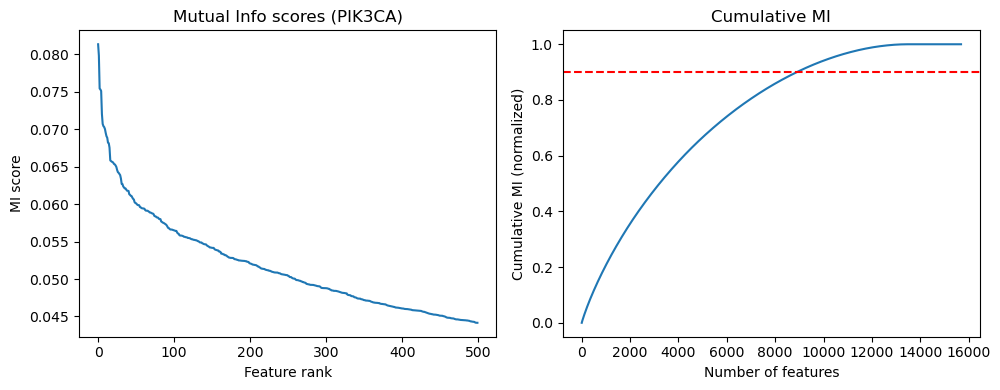

Features with MI > 0: 13496


In [117]:
target_gene = 'PIK3CA'
X_train, Y_train = prepare_ml_data(merged_expr = merged_expr, merged_mut = merged_mut, target_gene = 'PIK3CA')

# Compute mutual info (slower than f_classif)
print("Computing mutual information scores (this may take a minute)...")
mi_scores = mutual_info_classif(X_train, Y_train, random_state=1234)

# Sort and plot
sorted_scores = np.sort(mi_scores)[::-1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(sorted_scores[:500])
plt.xlabel('Feature rank')
plt.ylabel('MI score')
plt.title(f'Mutual Info scores ({target_gene})')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(sorted_scores) / np.sum(sorted_scores))
plt.xlabel('Number of features')
plt.ylabel('Cumulative MI (normalized)')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative MI')
plt.tight_layout()
plt.show()

# How many features have MI > 0?
n_informative = (mi_scores > 0).sum()
print(f"Features with MI > 0: {n_informative}")

In [122]:
target_gene = 'PIK3CA'
X_train, Y_train = prepare_ml_data(merged_expr = merged_expr, merged_mut = merged_mut, target_gene = 'PIK3CA')

def select_top_variance(X_train, n_top=3000): #like scRNA
    """Select top N var genes"""
    sel = VarianceThreshold(threshold=.1)
    sel_features = sel.fit_transform(features)
    print(sel_features)
    
    
    # variances = X_train.var(axis=0)
    # top_genes = variances.nlargest(n_top).index
    # return X[top_genes], top_genes

select_top_variance(X_train, n_top=3000)


# # Update merged_expr to keep only high-variance genes
# merged_expr_filtered = merged_expr.loc[top_genes]
# print(f"Filtered expression: {merged_expr_filtered.shape}")

[[2.93898809 6.05822475 4.25387844 ... 6.53673605 5.43036766 4.20172917]
 [0.77335282 6.80548242 2.55080061 ... 5.67900809 4.76635751 2.81591067]
 [0.45205378 7.05329671 2.99112193 ... 6.47565116 4.88257985 4.00787224]
 ...
 [1.91064147 4.45141259 3.09581215 ... 6.23145898 5.22461875 3.92202376]
 [1.93734407 4.78874002 2.44880866 ... 7.78789079 3.91698465 3.45883325]
 [6.79184241 3.08988568 2.90447293 ... 5.74675977 4.67082698 4.12441083]]
[ True False  True ...  True  True  True]


In [ ]:
target_genes = ['PIK3CA']#['RYR2', 'AKAP9', 'DNAH11', 'TP53', 'UTRN', 'HERC2', 'DNAH2', 'PIK3CA']

param_grid = { # dict
    'C': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

results = {}

for gene in target_genes:
    print(f"\n=== {gene} ===")
    
    if gene not in merged_mut.index:
        print(f"Skipping: not in mutation data")
        continue
    
    # Prepare
    X_train, Y_train = prepare_ml_data(merged_expr, merged_mut, gene)
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Grid search
    model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=3000,
        tol=1e-3,
        warm_start=True,
        random_state=1234
    )
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        # verbose=0
        refit=True  # refits best model on ALL training data
    )
    grid_search.fit(X_scaled, Y_train)
    
    # Results
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best AUC: {grid_search.best_score_:.3f}")
    
    best_model = grid_search.best_estimator_
    n_features = (best_model.coef_ != 0).sum()
    print(f"Features used: {n_features}")
    
    # Store results
    results[gene] = {
        'best_params': grid_search.best_params_,
        'best_auc': grid_search.best_score_,
        'n_features': n_features
    }
    
    # Predict
    X_test_scaled = scaler.transform(test_X)
    P_mutated = best_model.predict_proba(X_test_scaled)[:, 1] #P(class=1) = P(mutated)
    # print(P_mutated)

    
    # Output
    out = open('%s_%s.txt'%(args.output_prefix,gene),'wt')
    for (name,p) in sorted(zip(test_X.index, P_mutated)):
        out.write('%s %.5f\n'%(name,p))

# Summary
print(f"\n{'='*50}")
print("Summary:")
for gene, res in results.items():
    print(f"{gene}: AUC={res['best_auc']:.3f}, C={res['best_params']['C']}, l1_ratio={res['best_params']['l1_ratio']}, features={res['n_features']}")


=== PIK3CA ===


/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/ix/ccdg/storage3/til177/custom_miniconda/envs/hugen_general/lib/python3.11/site-packages/sklearn/li